In [6]:

!pip install mlflow boto3 awscli

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\DARSHAN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
# Configure AWS credentials using environment variables (safer for notebooks)
import os

# Set your AWS credentials here
os.environ['AWS_ACCESS_KEY_ID'] = 'your-access-key-id'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'your-secret-access-key'
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'  # Change to your region

# Or use boto3 directly
import boto3
boto3.setup_default_session(
    aws_access_key_id='your-access-key-id',
    aws_secret_access_key='your-secret-access-key',
    region_name='us-east-1'
)

In [8]:
import mlflow
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-184-72-133-224.compute-1.amazonaws.com:5000/")

In [9]:
mlflow.set_experiment("Exp 2 - BoW vs TfIdf")

<Experiment: artifact_location='s3://mlflow-darshan/2', creation_time=1770616960219, experiment_id='2', last_update_time=1770616960219, lifecycle_stage='active', name='Exp 2 - BoW vs TfIdf', tags={}>

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [12]:
df = pd.read_csv(r'E:\PROJECT_3rd\end-to-end MLops\notebook\reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

🏃 View run BoW_(1, 1)_RandomForest at: http://ec2-184-72-133-224.compute-1.amazonaws.com:5000/#/experiments/2/runs/65378382c197429a8ec81704fe9cc065
🧪 View experiment at: http://ec2-184-72-133-224.compute-1.amazonaws.com:5000/#/experiments/2


S3UploadFailedError: Failed to upload confusion_matrix.png to mlflow-darshan/2/65378382c197429a8ec81704fe9cc065/artifacts/confusion_matrix.png: An error occurred (InvalidAccessKeyId) when calling the PutObject operation: The AWS Access Key Id you provided does not exist in our records.

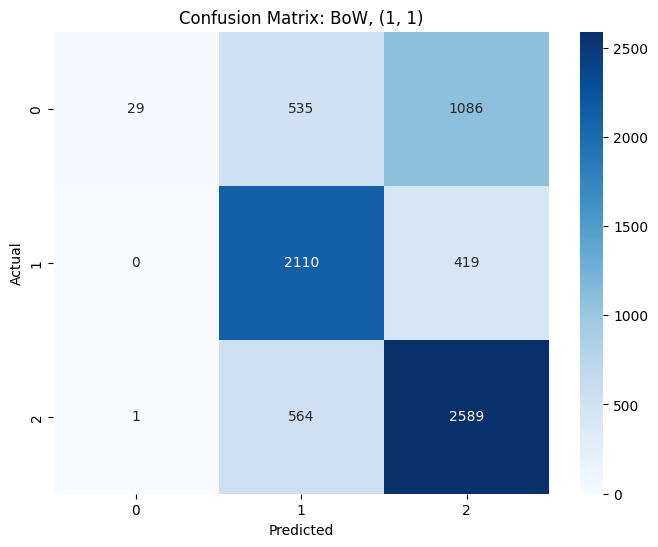

In [13]:
# Step 1: Function to run the experiment
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):
    # Step 2: Vectorization
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(df['clean_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 4: Define and train a Random Forest model
    with mlflow.start_run() as run:
        # Set tags for the experiment and run
        mlflow.set_tag("mlflow.runName", f"{vectorizer_name}_{ngram_range}_RandomForest")
        mlflow.set_tag("experiment_type", "feature_engineering")
        mlflow.set_tag("model_type", "RandomForestClassifier")

        # Add a description
        mlflow.set_tag("description", f"RandomForest with {vectorizer_name}, ngram_range={ngram_range}, max_features={vectorizer_max_features}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("vectorizer_max_features", vectorizer_max_features)

        # Log Random Forest parameters
        n_estimators = 200
        max_depth = 15

        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)

        # Initialize and train the model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)

        # Step 5: Make predictions and log metrics
        y_pred = model.predict(X_test)

        # Log accuracy
        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)

        # Log classification report
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in classification_rep.items():
            if isinstance(metrics, dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)

        # Log confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.close()

        # Log the model
        mlflow.sklearn.log_model(model, f"random_forest_model_{vectorizer_name}_{ngram_range}")

# Step 6: Run experiments for BoW and TF-IDF with different n-grams
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # unigrams, bigrams, trigrams
max_features = 5000  # Example max feature size

for ngram_range in ngram_ranges:
    # BoW Experiments
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")

    # TF-IDF Experiments
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")